# VHS/ HSC WIDE run

In this directory we are performing an all band selected processing of VHS J,H,Ks and HSC G,R,I,Z,Y PDR2 WIDE data.

This was originally only producing files for the XMM W02 field but now produces dictionaries for all fields.

In this notebook we plot the VHS tiles, over the tracts to patches to check coverages and then create the slurm jobs required to send the jobs to IRIS as arrays. We will also calculate times based on benchmarking on the SXDS field.

We will try to make a job dictionary for each field independently.

In [5]:
from astropy.table import Table,Column
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import json

#We are using a rings skymap
from lsst.geom import SpherePoint 
from lsst.geom import degrees
from lsst.skymap.ringsSkyMap import RingsSkyMap, RingsSkyMapConfig

config = RingsSkyMapConfig()
#These config options are chose to be the same as HSC:
#https://github.com/lsst/obs_subaru/blob/master/config/hsc/makeSkyMap.py
config.numRings = 120
config.projection = "TAN"
config.tractOverlap = 1.0/60 
config.pixelScale = 0.168
sm = RingsSkyMap(config)

In [6]:
#vhs_ims = Table.read('../../dmu1/data/vhs_images_overview_20201102.csv')
vhs_ims = Table.read('../../dmu1/data/vhs_images_overview_20210409.csv')
hsc_ims = Table.read('../../dmu1/data/hsc_images_overview_20210315.csv')

In [7]:
vhs_total_patch_dict = json.loads(open('../../dmu1/json/vhs_total_patch_dict.json', 'r').read())

In [8]:
hsc_bands = ['G', 'R', 'I', 'Z', 'Y']
vista_bands = ['Y', 'J', 'H', 'Ks']
patch_files = {
    'w01':'../../dmu0/dmu0_HSC/tracts_patches/tracts_patches_W-w01.txt',
    'w02':'../../dmu0/dmu0_HSC/tracts_patches/tracts_patches_W-w02.txt',
    'w03':'../../dmu0/dmu0_HSC/tracts_patches/tracts_patches_W-w03.txt',
    'w04':'../../dmu0/dmu0_HSC/tracts_patches/tracts_patches_W-w04.txt',
    'w05':'../../dmu0/dmu0_HSC/tracts_patches/tracts_patches_W-w05.txt',
}

## 1. Plot the regions and compute tile/patch numbers

In [9]:
vhs_ims.add_column(Column(
    data= [t.split('/')[-2] for t in vhs_ims['file']],
    name='date'))

In [10]:
def fileToNumObs(filename):
    "Parse the file name to an obsNum"
    numObs = filename.split('_')[1].strip('_st_tl_conf.fit')
    return numObs
vhs_ims['numObs'] = [fileToNumObs(f) for f in vhs_ims['file']]

In [11]:
hsc_ims['tract'] = [f.split('/')[16] for f in hsc_ims['file']]
hsc_ims['patch'] = [f.split('/')[17] for f in hsc_ims['file']]
hsc_ims['depth'] = [f.split('/')[13] for f in hsc_ims['file']]
hsc_ims['band'] = [f.split('-')[-3] for f in hsc_ims['file']]

In [12]:
hsc_ims[-1]

file,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,size,hash,tract,patch,depth,band
str270,float64,float64,float64,float64,float64,float64,float64,float64,int64,str32,str5,str3,str9,str1
"/home/ir-shir1/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_HSC/data/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_wide/deepCoadd-results/HSC-I/9078/0,4/calexp-HSC-I-9078-0,4.fits",140.6753438834335,140.67523185607436,140.4838851380322,140.48379862049953,-2.329154427345173,-2.1331757109236142,-2.329255511739157,-2.1332682816908735,120049920,90a7d75222f09ea4ac74b54da02f160c,9078,"0,4",pdr2_wide,I


In [13]:
def fileToType(filename):
    filetype = ''
    types = {
        'tile':'_tl.fit',
        'stack':'_st.fit',
    }
    for k,v in types.items():
        #print(k,v)
        if filename.endswith(v):
            filetype = k
  
    return filetype
vhs_ims['type'] = [fileToType(f) for f in vhs_ims['file']]

In [14]:
"Out of {} files in VHS there are {} stack images".format(len(vhs_ims),np.sum(vhs_ims['type']=='stack'))

'Out of 887732 files in VHS there are 204996 stack images'

In [15]:
lims={ #.     [ra_min, ra_max, dec_min, dec_max]  manually from HSC pages first integer value outside tract
    'w01':    [14,     24,     -3,      4],  
    'w02':    [27,     41,     -8,      6],   #XMM
    'w03':    [125,    165,    -3,      6], 
    'w04':    [160,    235,    -5,      6], 
    'w05':    [326,    375,    -3,      8], 
}

## Check the basic numbers

Lets look at how many VHS stack images there are in each field.

In [16]:
vhs_near={}
vhs_ims_per_field={}
for i in np.arange(1,6):
    field='w0{}'.format(i)
    vhs_near[field] = (
        (vhs_ims['ra'] > lims[field][0])
        & (vhs_ims['ra'] < lims[field][1])
        & (vhs_ims['dec'] > lims[field][2])
        & (vhs_ims['dec'] < lims[field][3])
    )


    vhs_ims_per_field[field] = vhs_ims[vhs_near[field]]

    print(
        "Field {}: {} VHS files, {} stack images.".format(
            field,
            np.sum(vhs_near[field]), 
            np.sum(vhs_near[field] & (vhs_ims['type']=='stack'))
        )
    )

Field w01: 3921 VHS files, 943 stack images.
Field w02: 8818 VHS files, 2100 stack images.
Field w03: 5043 VHS files, 1211 stack images.
Field w04: 2350 VHS files, 564 stack images.
Field w05: 9813 VHS files, 2356 stack images.


In [17]:
"Total VHS stacks near HSC: {}".format(
    np.sum(
        [
            np.sum(
                vhs_near['w0{}'.format(f)]& (vhs_ims['type']=='stack')
            ) for f in np.arange(1,6)
        ]
    )
)

'Total VHS stacks near HSC: 7174'

In [18]:
"There are {} stack files in total".format(np.sum(vhs_ims['type']=='stack'))

'There are 204996 stack files near XMM'

In [19]:
vhs_ims[:1]

file,ra,dec,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,filter,size,visit,exptime,hash,MAGZPT,MAGZRR,SEEING,SKYLEVEL,SKYNOISE,OBSTATUS,ESOGRADE,OBSNUM,date,numObs,type
str96,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,int64,int64,int64,int64,float64,float64,float64,float64,float64,str10,str1,int64,str8,str5,str5
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VHS/20141227/v20141227_00209.fit,165.909204,-28.5373,166.48243879910171,166.48492772948782,166.26531269213137,166.2668909106407,-27.892891295875494,-28.084231071711308,-27.892406165119358,-28.084077318584885,Ks,92422080,51445,15,--,nan,nan,nan,nan,nan,--,--,0,20141227,00209,


In [21]:
vhs_ims['ESOGRADE'] = vhs_ims['ESOGRADE'].filled()
vhs_ims['OBSTATUS'] = vhs_ims['OBSTATUS'].filled()

In [22]:
for obstatus in np.unique(vhs_ims['OBSTATUS']):

    print("{} stacks with OBSTATUS={}".format(
        np.sum((vhs_ims['type']=='stack')&(vhs_ims['OBSTATUS']==obstatus)),
        obstatus
    ))

2953 stacks with OBSTATUS=Aborted
152197 stacks with OBSTATUS=Completed
18831 stacks with OBSTATUS=Executed
444 stacks with OBSTATUS=Must Repea
30571 stacks with OBSTATUS=N/A


In [23]:
for esograde in np.unique(vhs_ims['ESOGRADE']):

    print("{} stacks with ESOGRADE={}".format(
        np.sum((vhs_ims['type']=='stack')&(vhs_ims['ESOGRADE']==esograde)),
        esograde
    ))

119413 stacks with ESOGRADE=A
26478 stacks with ESOGRADE=B
18831 stacks with ESOGRADE=C
6306 stacks with ESOGRADE=D
30571 stacks with ESOGRADE=N
2953 stacks with ESOGRADE=R
444 stacks with ESOGRADE=X


In [24]:
np.unique(vhs_ims[~vhs_ims['filter'].mask]['filter'])

H
J
Ks
Y


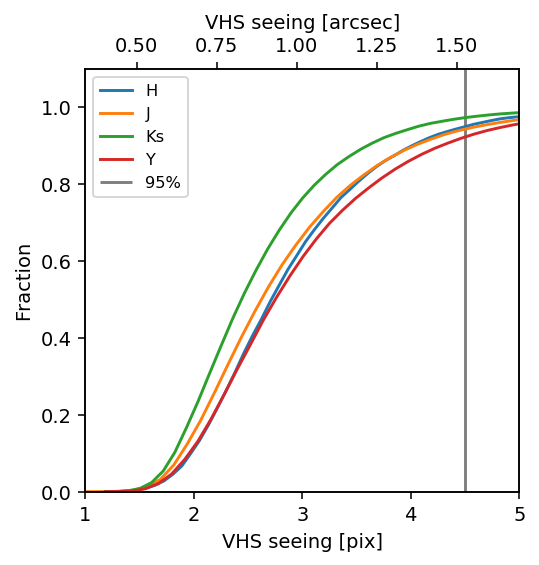

In [33]:
fig = plt.figure(figsize=(4, 4), dpi=140)
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
x_lims=[1,5]
pixwidth=0.339
#hist=np.histogram(video_ims[near_sxds]['SEEING'],bins=100)
#X=[np.mean([hist[1][n],hist[1][n+1]]) for n in np.arange(len(hist[1])-1)] 
#Y=hist[0]
for band in np.unique(vhs_ims[~vhs_ims['filter'].mask]['filter']):

    #print(band)
    m = (vhs_ims['SEEING']>0) & (vhs_ims['filter']==band)


    hist=np.histogram(vhs_ims[m]['SEEING'],bins=100)
    bin_edges=hist[1]
    bin_middles = (bin_edges[1:] + bin_edges[:-1])/2
    cum_sum=np.cumsum(hist[0])/np.sum(hist[0])
    ax1.plot(bin_middles,cum_sum,label=band)

    ax1.set_ylim([0,1.1])
    ax1.set_xlabel(r"VHS seeing [pix]")
    ax1.set_xlim(x_lims)
    ax1.set_ylabel('Fraction')
    

seeing_p95=np.nanpercentile(vhs_ims['SEEING'],95)
ax1.vlines(seeing_p95,0,1.1,alpha=0.5,label='95%')

ax1.legend(fontsize='small')

new_tick_locations = np.array([0.5,0.75,1,1.25,1.5])/pixwidth
def tick_function(X):
    V = X*pixwidth
    return ["%.2f" % z for z in V]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"VHS seeing [arcsec]")
fig.savefig('./figs/vhs_seeing_hist.pdf', overwrite=True, bbox_inches='tight')
fig.savefig('./figs/vhs_seeing_hist.png', overwrite=True, bbox_inches='tight')

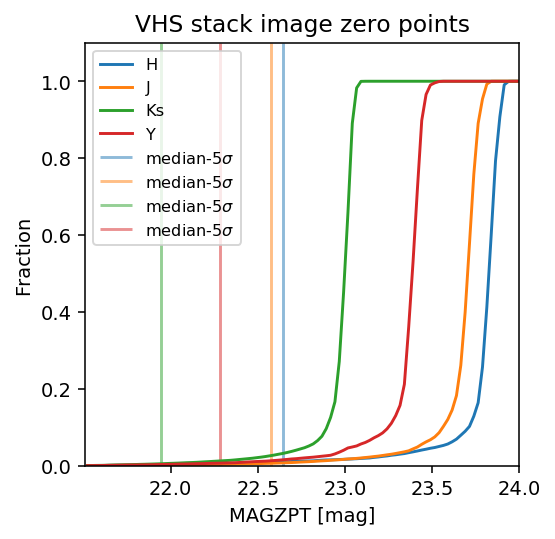

In [40]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=140)

x_lims=[
    np.nanpercentile(vhs_ims['MAGZPT'],0.5),
    np.nanpercentile(vhs_ims['MAGZPT'],99.9)+0.5
]
x_lims=[21.51,24.]
ax.set_title('VHS stack image zero points')
for band in np.unique(vhs_ims[~vhs_ims['filter'].mask]['filter']):

    #print(band)
    m = (vhs_ims['SEEING']>0) & (vhs_ims['filter']==band)
    
     
    zp_p1_band=np.nanpercentile(vhs_ims[m]['MAGZPT'],1)
    
    med = np.nanmedian(vhs_ims[m]['MAGZPT'])
    std = np.nanstd(vhs_ims[m]['MAGZPT'])


    hist=np.histogram(vhs_ims[m]['MAGZPT'],bins=100,range=x_lims)
    bin_edges=hist[1]
    bin_middles = (bin_edges[1:] + bin_edges[:-1])/2
    cum_sum=np.cumsum(hist[0])/np.sum(hist[0])
    line=ax.plot(bin_middles,cum_sum,label=band)
    ax.vlines(med-5*std,0,1.1,colors=line[0].get_color(),alpha=0.5,label='median-5$\sigma$')
    
    ax.set_xlabel(r"Seeing [pix]")
    
    ax.set_ylabel('Fraction')
 
ax.set_ylim([0,1.1])
ax.set_xlim(x_lims)

ax.set_xlabel(r"MAGZPT [mag]")
#ax.set_xlim(lims)
ax.set_ylabel('Fraction')
ax.legend(fontsize='small')
fig.savefig('./figs/vhs_zp_hist.pdf', overwrite=True, bbox_inches='tight')
fig.savefig('./figs/vhs_zp_hist.png', overwrite=True, bbox_inches='tight')

In [36]:
m = vhs_ims['type']=='stack'
zpt_mask=m
for band in np.unique(vhs_ims[~vhs_ims['filter'].mask]['filter']):

    #print(band)
    band_mask= (vhs_ims['filter']==band)
    zp_p1_band=np.nanpercentile(vhs_ims[band_mask]['MAGZPT'],1)
    
    med = np.nanmedian(vhs_ims[band_mask]['MAGZPT'])
    std = np.nanstd(vhs_ims[band_mask]['MAGZPT'])
    
    # Use first percentile as mask
    #zpt_mask=(band_mask & (video_ims['MAGZPT']>zp_p1_band)) | (~band_mask & zpt_mask)
    # Use 5 standard deviations below median as mask
    zpt_mask=(band_mask & (vhs_ims['MAGZPT']>med - 5*std)) | (~band_mask & zpt_mask)
    
seeing_lim = 5 #pixels
print(
    np.sum(m),
    np.sum( m&(zpt_mask)),
    np.sum( (zpt_mask) & (vhs_ims['SEEING']<seeing_lim)),
    np.sum(
        (zpt_mask) 
        & (vhs_ims['SEEING']<seeing_lim) 
        & (vhs_ims['OBSTATUS']=='Completed')
    ),
    np.sum(
        (zpt_mask) 
        & (vhs_ims['SEEING']<seeing_lim) 
        & (vhs_ims['OBSTATUS']=='Completed')
        & (vhs_ims['ESOGRADE']=='A')
    ),
    np.sum(
        (vhs_ims['SEEING']<seeing_lim) 
        & ~((vhs_ims['OBSTATUS']=='Must Repea')|(vhs_ims['OBSTATUS']=='Aborted'))
    ),
    np.sum(
        (zpt_mask) 
        & (vhs_ims['SEEING']<seeing_lim) 
        & (
            (vhs_ims['ESOGRADE']=='A')
            |(vhs_ims['ESOGRADE']=='B')
            |(vhs_ims['ESOGRADE']=='C')
            |(vhs_ims['ESOGRADE']=='N'))
    )
)

204996 203208 197638 150407 118662 196376 189048


In [37]:
good = (
    (zpt_mask) 
    & (vhs_ims['SEEING']<seeing_lim) 
    & ~((vhs_ims['OBSTATUS']=='Must Repea')|(vhs_ims['OBSTATUS']=='Aborted'))
)
print("Keeping {} percent".format(round(100*np.sum(good)/np.sum(vhs_ims['type']=='stack'),2)))

Keeping 95.02 percent


## Plot the VHS/Wide fields to check coverage

We will plot the fields to visualise the overlap and check that the patch dictionaries look sensible

### Overlap patches

Lets get the total overlap of patches in HSC that are also in any VHS tile

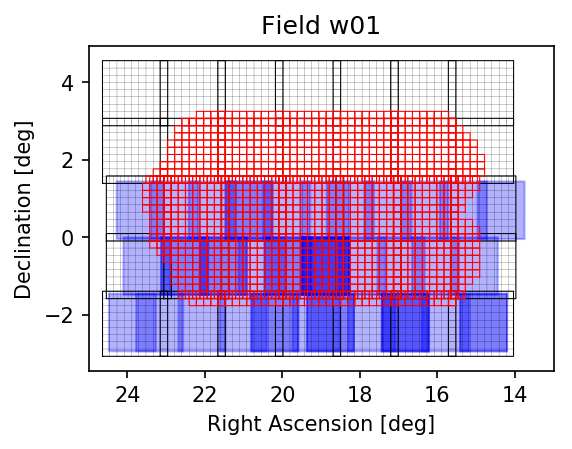

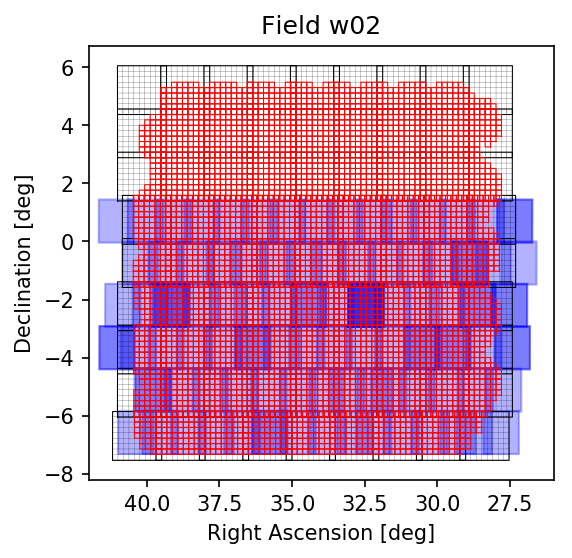

In [123]:
for i in np.arange(1,3):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
    field = 'w0{}'.format(i)

    #Get official list of tracts that define field
    f = open(patch_files[field], 'r')
    tracts = set()
    for x in f:
        if x.startswith('Tract'):
            tracts.add(int(x.split(' ')[1]))  
    full_patch_dict = {}
    band_dict = { hsc_bands[i]: {} for i in range(len(hsc_bands))}
    for tract in tracts:
        full_patch_dict[tract] = [
            s for s in np.unique(np.array(hsc_ims[ (hsc_ims['tract'] == str(tract))]['patch']))
        ]
        for band in hsc_bands:
            band_dict[band][tract] = [
                s for s in np.unique(np.array(hsc_ims[
                    (hsc_ims['tract'] == str(tract))
                    & (hsc_ims['band'] == band)
                ]['patch']))
            ]

    #Plot all the tracts and patchs as a grey background        
    for tract in tracts:
        vertices = sm.generateTract(tract).getVertexList()
        ra = [vertices[n][0].asDegrees() for n in np.mod(np.arange(5),4)]
        dec = [vertices[n][1].asDegrees() for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'k', linewidth=0.5)
        for p in np.nditer(np.meshgrid(np.arange(0,9), np.arange(0,9))):
            #print(p[0], p[1])
            t = sm.generateTract(tract)
            vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
            ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
            #print(tract, ra)
            dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
            ax.plot(ra, dec, c = 'k', alpha=0.5, linewidth=0.1)

    #Plot patches that have HSC files on a band
    band = 'all'
    if band != 'all':
        d = band_dict[band]
    else:
        d = full_patch_dict
    for tract in d:
        for patch in d[tract]:
            #print(p[0], p[1])
            p = [int(i) for i in patch.split(',')]
            t = sm.generateTract(tract)
            vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
            ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
            #print(tract, ra)
            dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
            ax.plot(ra, dec, c = 'r', alpha=1.0, linewidth=0.5)


    v_band ='Ks'
    for t in vhs_ims[vhs_near[field] & (vhs_ims['type'] == 'tile') & (vhs_ims['filter'] == v_band) ]:

        ra = [t['ra_0_0'], t['ra_x_0'] , t['ra_x_y'] , t['ra_0_y'] , t['ra_0_0'] ]
        dec = [t['dec_0_0'], t['dec_x_0'] , t['dec_x_y'] , t['dec_0_y'] , t['dec_0_0'] ]

        ax.fill(ra,dec, c = 'b', alpha=0.3)



    ax.set_title("Field {}".format(field))
    ax.axis('scaled')
    ax.set_xlim([lims[field][1]+1, lims[field][0]-1])
    ax.set_xlabel('Right Ascension [deg]')
    ax.set_ylabel('Declination [deg]')
    plt.show()
    fig.savefig('./figs/{}_HSC-{}_tracts.pdf'.format(field,band), overwrite=True)
    fig.savefig('./figs/{}_HSC-{}_tracts.png'.format(field,band), overwrite=True)

Field: w03


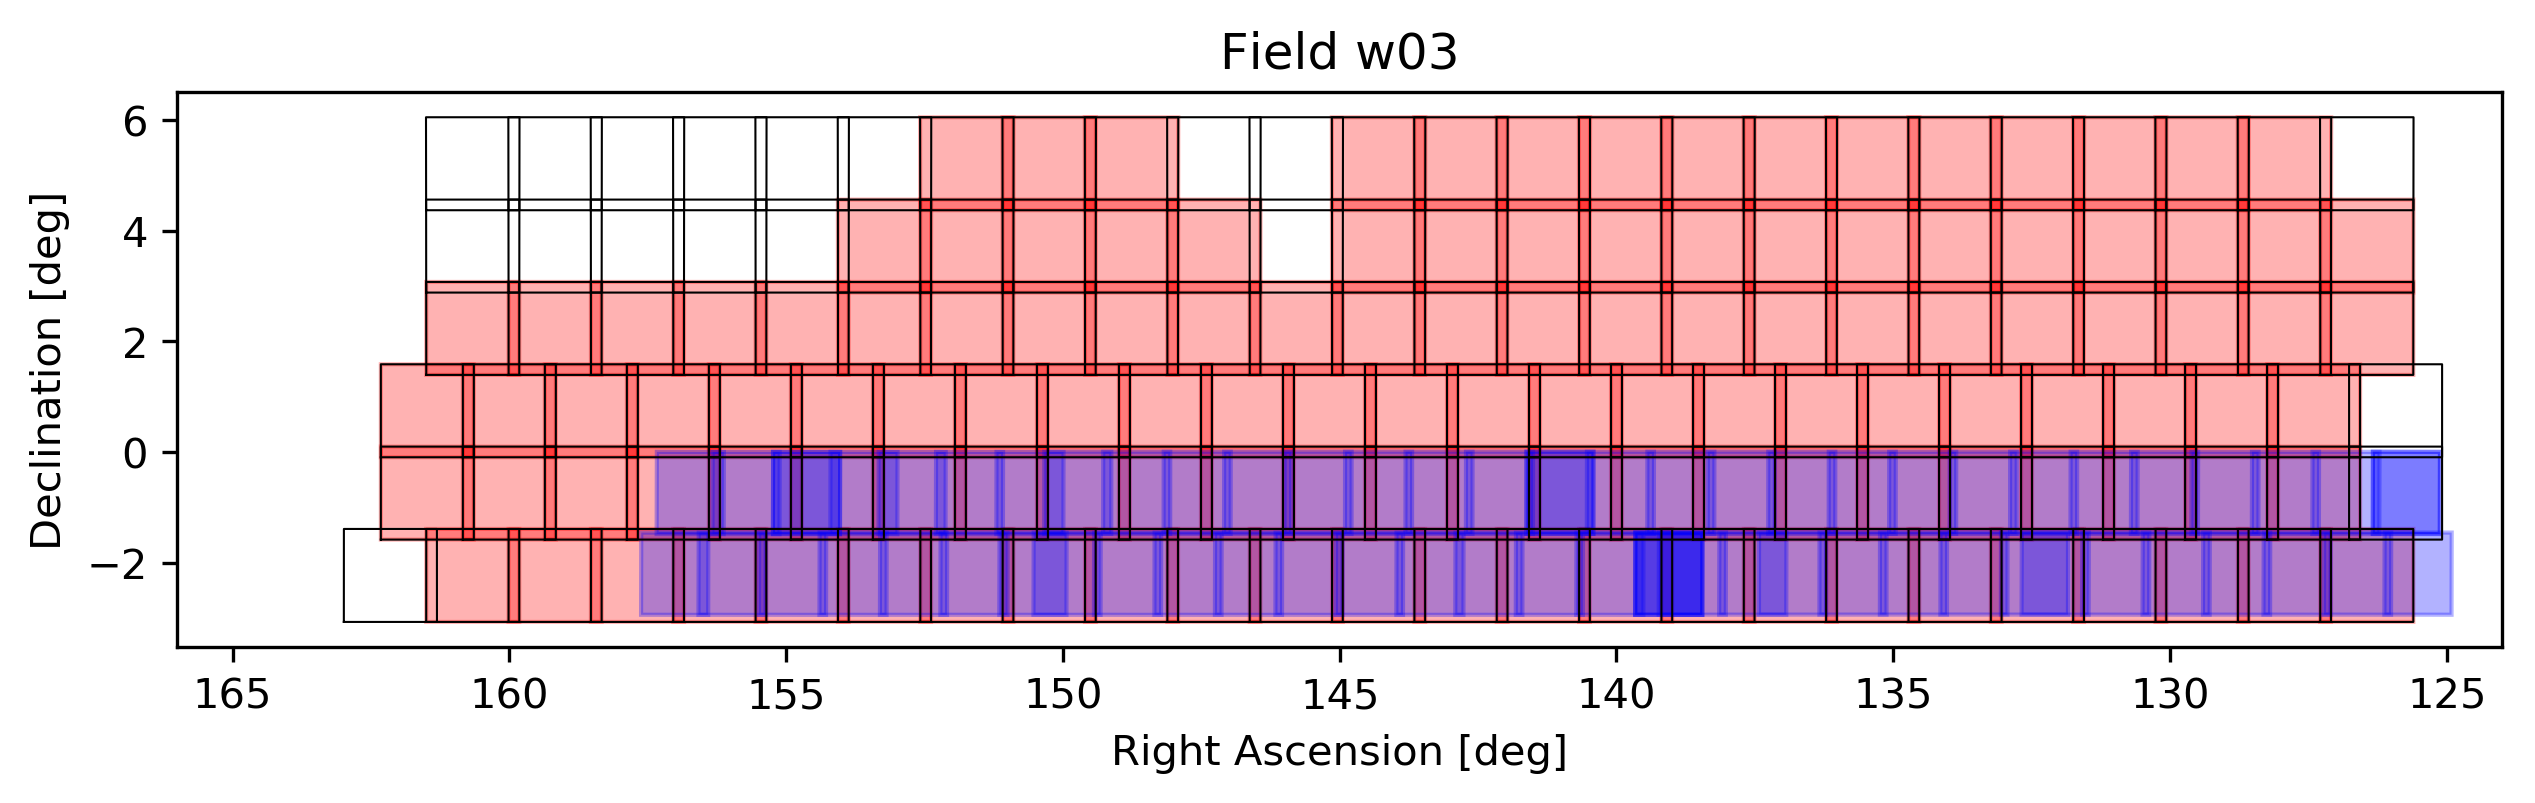

Field: w04


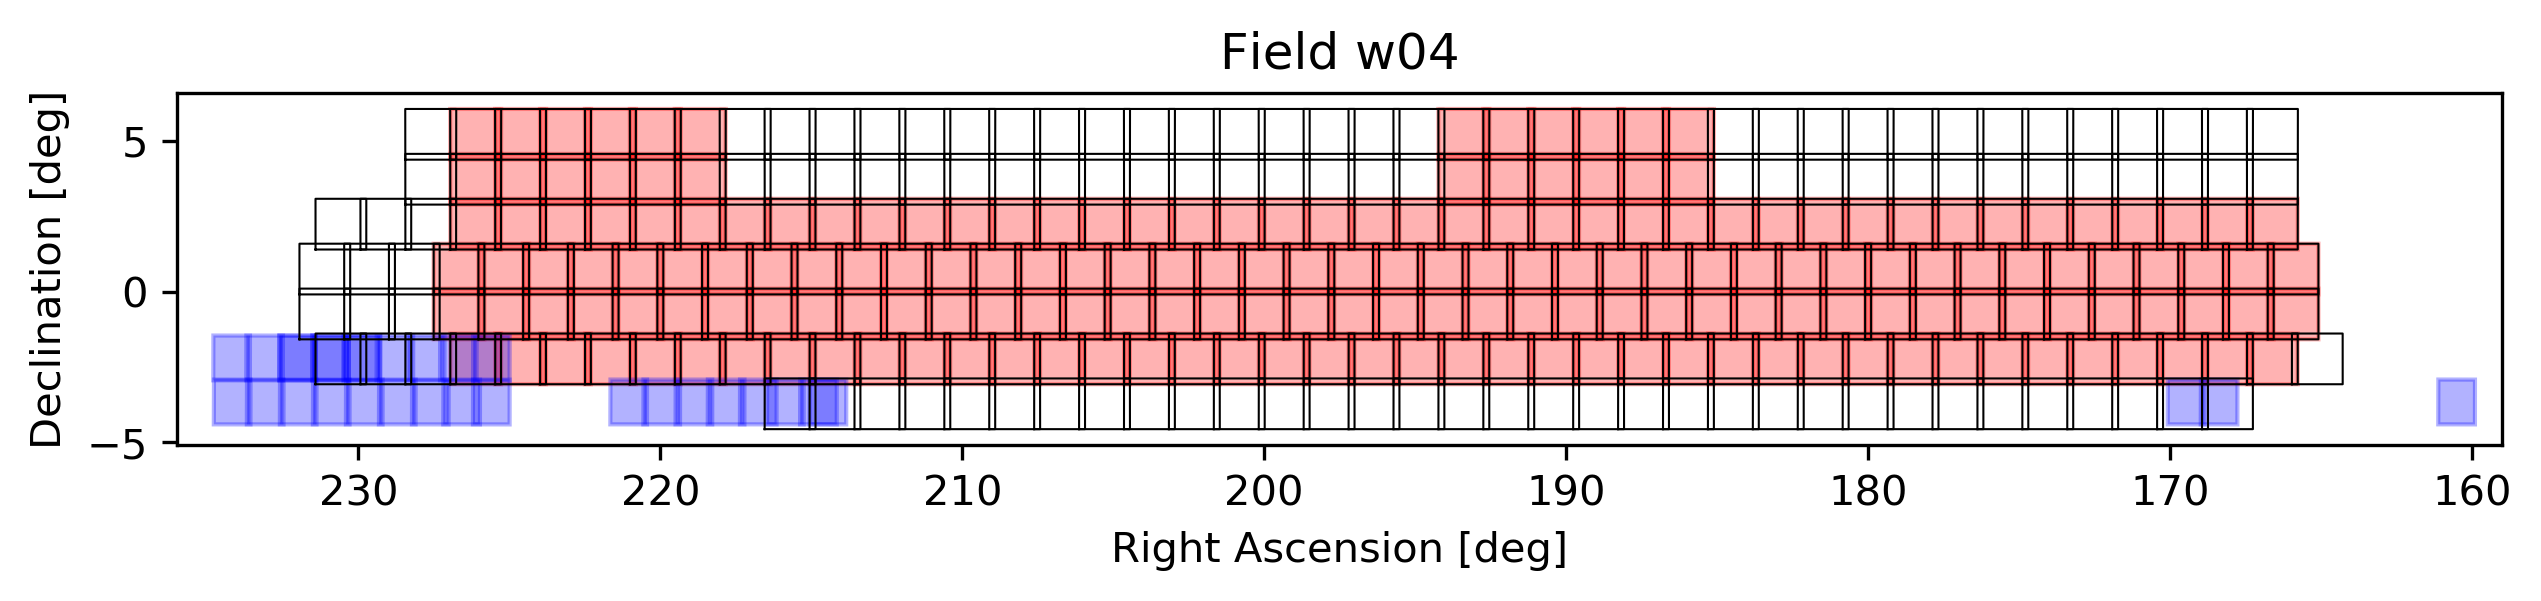

Field: w05


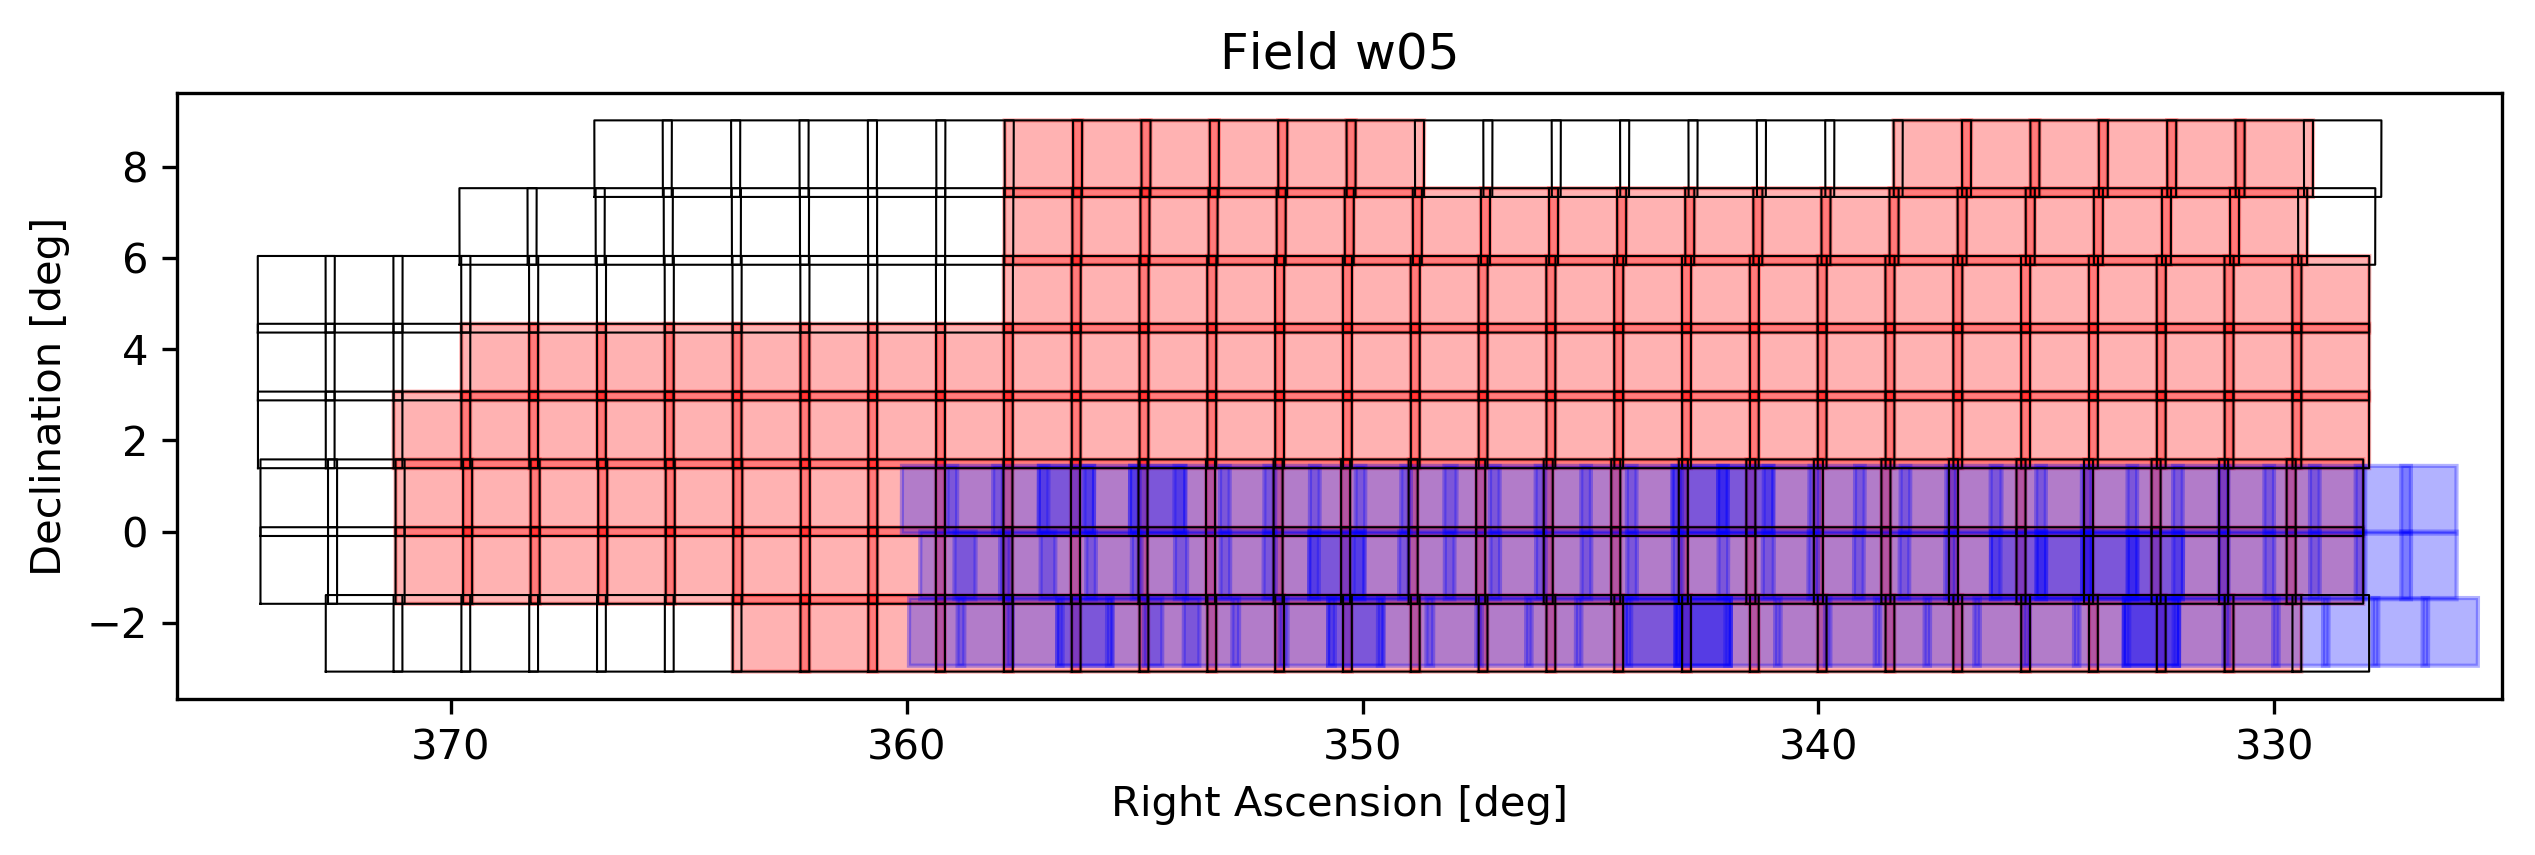

In [121]:
for i in np.arange(3,6):
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    field = 'w0{}'.format(i)
    print('Field: {}'.format(field))
    #Get official list of tracts that define field
    f = open(patch_files[field], 'r')
    tracts = set()
    for x in f:
        if x.startswith('Tract'):
            tracts.add(int(x.split(' ')[1]))  
    full_patch_dict = {}
    band_dict = { hsc_bands[i]: {} for i in range(len(hsc_bands))}
    for tract in tracts:
        full_patch_dict[tract] = [
            s for s in np.unique(np.array(hsc_ims[ (hsc_ims['tract'] == str(tract))]['patch']))
        ]
        for band in hsc_bands:
            band_dict[band][tract] = [
                s for s in np.unique(np.array(hsc_ims[
                    (hsc_ims['tract'] == str(tract))
                    & (hsc_ims['band'] == band)
                ]['patch']))
            ]

    #Plot all the tracts and patchs as a grey background        
    for tract in tracts:
        vertices = sm.generateTract(tract).getVertexList()
        ra = [vertices[n][0].asDegrees() for n in np.mod(np.arange(5),4)]
        for i in np.arange(5):
            if ra[i]<100:
                ra[i] = ra[i]+360
        dec = [vertices[n][1].asDegrees() for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'k', linewidth=0.5)
#         for p in np.nditer(np.meshgrid(np.arange(0,9), np.arange(0,9))):
#             #print(p[0], p[1])
#             t = sm.generateTract(tract)
#             vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
#             ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
#             #print(tract, ra)
#             dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
#             ax.plot(ra, dec, c = 'k', alpha=0.5, linewidth=0.1)

    #Plot tracts?patches that have HSC files on a band
    band = 'all'
    if band != 'all':
        d = band_dict[band]
    else:
        d = full_patch_dict
    for tract in d:
        if  len(d[tract])==0:
            continue
        vertices = sm.generateTract(tract).getVertexList()
        ra = [vertices[n][0].asDegrees() for n in np.mod(np.arange(5),4)]
        for i in np.arange(5):
            if ra[i]<100:
                ra[i] = ra[i]+360
        dec = [vertices[n][1].asDegrees() for n in np.mod(np.arange(5),4)]
        ax.fill(ra, dec, c = 'r', alpha=0.3)
#         for patch in d[tract]:
#             #print(p[0], p[1])
#             p = [int(i) for i in patch.split(',')]
#             t = sm.generateTract(tract)
#             vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
#             ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
#             #print(tract, ra)
#             dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
#             #ax.plot(ra, dec, c = 'r', linewidth=0.6)
#             ax.fill(ra, dec, c = 'r', alpha=0.3)


    v_band ='Ks'
    for t in vhs_ims[vhs_near[field] & (vhs_ims['type'] == 'tile') & (vhs_ims['filter'] == v_band) ]:

        ra = [t['ra_0_0'], t['ra_x_0'] , t['ra_x_y'] , t['ra_0_y'] , t['ra_0_0'] ]
        dec = [t['dec_0_0'], t['dec_x_0'] , t['dec_x_y'] , t['dec_0_y'] , t['dec_0_0'] ]
        for i in np.arange(5):
            if ra[i]<100:
                ra[i] = ra[i]+360
        ax.fill(ra,dec, c = 'b', alpha=0.3)



    ax.set_title("Field {}".format(field))
    ax.axis('scaled')
    ax.set_xlim([lims[field][1]+1, lims[field][0]-1])
    ax.set_xlabel('Right Ascension [deg]')
    ax.set_ylabel('Declination [deg]')
    plt.show()
    fig.savefig('./figs/{}_HSC-{}_tracts.pdf'.format(field,band), overwrite=True)
    fig.savefig('./figs/{}_HSC-{}_tracts.png'.format(field,band), overwrite=True)

In [111]:
#How many diferent exposure times for stacks are there
np.unique(vhs_ims[(vhs_ims['type'] == 'stack')  ]['exptime'])

1
5
7
10
15
30


## 1. Make the image job dictionaries

We will now create a dictionary mapping integer 0 indexed job ids to job options to reduce the number of slurm files required. This dictionary can then be saved as a json file and passed to the bash script which runs the process. We may wish to move to pure Python to make this more tidy. 

In [137]:
print(
    np.min([int(d) for d in vhs_ims[(vhs_ims['type'] == 'stack')]['date']]), 
    np.max([int(d) for d in vhs_ims[(vhs_ims['type'] == 'stack')]['date']])
)

20091103 20200315


In [139]:
def raDecToTractSafe(ra,dec):
    """Return all the tracts within 2 degrees of a ra dec to get every tract covering a tile
    
    I think the function findTractPatchList excludes all tracts that do not conatin the points
    Crucially this excluded the central tracts. Perhaps we need to get the corners from the tile.
    
    """
    size = 2 #degrees safely outside tile from centre
    patches= sm.findTractPatchList([
        SpherePoint((ra)*degrees,(dec)*degrees)
        for ra, dec in np.nditer(
            np.meshgrid(
                np.linspace(ra+size,ra-size,num=int(size/0.5)),
                np.linspace(dec+size,dec-size,num=int(size/0.5)),
            )
        )
    ])
    tracts = set([p[0].getId() for p in patches])
    t =''
    for n in tracts:
        t += '^{}'.format(n)
    return t[1:]
    
print(
    vhs_ims[(vhs_ims['type'] == 'stack')][0]['ra'], 
    vhs_ims[(vhs_ims['type'] == 'stack')][0]['dec'],
    raDecToTractSafe(
        vhs_ims[(vhs_ims['type'] == 'stack')][0]['ra'],
        vhs_ims[(vhs_ims['type'] == 'stack')][0]['dec']
    )
)

89.6062 -10.8541 7840^7361^7362^7363^8077^8078^8079^8080^7601^7600^7599^7598^7837^7838^7839


In [143]:
for i in np.arange(1,6):
    field = 'w0{}'.format(i)
    images_job_dict = {}
 
    ims_to_run=vhs_ims[vhs_near[field] & (vhs_ims['type']=='stack')]
    n = len(ims_to_run)
    #Run over every stack image in the field
    for i in np.arange(n):
        date=ims_to_run[i]['date']
        images_job_dict[str(i)] = [
            '{}-{}-{}'.format(date[0:4],date[4:6],date[6:9]),
            ims_to_run[i]['numObs'],
            'VISTA-{}'.format(ims_to_run[i]['filter']),
            raDecToTractSafe(ims_to_run[i]['ra'],ims_to_run[i]['dec']),
            ims_to_run[i]['file']
        ]
    dict_name ='./slurm/{}_images_job_dict_{}.json'.format(field,n)
    print('Field {}: {} images, dict written to {}'.format(field,n,dict_name))
    with open(dict_name, 'w') as outfile:
        json.dump(images_job_dict, outfile, separators=(',', ':'))

Field w01: 943 images, dict written to ./slurm/w01_images_job_dict_943.json
Field w02: 2100 images, dict written to ./slurm/w02_images_job_dict_2100.json
Field w03: 1211 images, dict written to ./slurm/w03_images_job_dict_1211.json
Field w04: 564 images, dict written to ./slurm/w04_images_job_dict_564.json
Field w05: 2356 images, dict written to ./slurm/w05_images_job_dict_2356.json


# 2. Make the patch job array dictionaries

For each field we want the patches that are in HSC and have VHS coverage.

In [173]:
for i in np.arange(1,6):
    field = 'w0{}'.format(i)
    #get tracts in field
    tracts = set()
    for x in open(patch_files[field], 'r'):
        if x.startswith('Tract'):
            tracts.add(int(x.split(' ')[1]))  
    

    hsc_patch_dict = {}
    vhs_patch_dict = {}
    patch_job_dict = {}
    n=0
    for tract in tracts:
        hsc_patch_dict[tract] = [
            s for s in np.unique(np.array(hsc_ims[ (hsc_ims['tract'] == str(tract))]['patch']))
        ]
        try:
            vhs_patch_dict[tract] = ["{},{}".format(p[0],p[1]) for p in vhs_total_patch_dict[str(tract)]]
        except KeyError:
            vhs_patch_dict[tract] = []
        for patch in np.nditer(np.meshgrid(np.arange(9),np.arange(9))):
            patch="{},{}".format(patch[0],patch[1])
            #check if patch is in both regions
            in_hsc = patch in hsc_patch_dict[tract]
            in_vhs = patch in vhs_patch_dict[tract]
            if in_hsc and in_vhs:
                patch_job_dict[str(n)]=[tract, patch ]
                n+=1
    
   
    
    
    dict_name ='./slurm/{}_patch_job_dict_{}.json'.format(field,n)
    print('Field {}: {} patches, dict written to {}'.format(field,n,dict_name))
    with open(dict_name, 'w') as outfile:
        json.dump(patch_job_dict, outfile, separators=(',', ':'))

Field w01: 1039 patches, dict written to ./slurm/w01_patch_job_dict_1039.json
Field w02: 3996 patches, dict written to ./slurm/w02_patch_job_dict_3996.json
Field w03: 3107 patches, dict written to ./slurm/w03_patch_job_dict_3107.json
Field w04: 53 patches, dict written to ./slurm/w04_patch_job_dict_53.json
Field w05: 4969 patches, dict written to ./slurm/w05_patch_job_dict_4969.json
